In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [47]:
num_epochs = 20
batch_size = 256

# 定义数据预处理的transforms
transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),  # 随机水平翻转
    transforms.RandomCrop(32, padding = 4),  # 随机裁剪
    transforms.RandomRotation(15),  # 随机旋转
    transforms.RandomAffine(0, shear = 10, scale = (0.8, 1.2)),  # 随机仿射变换
    transforms.ColorJitter(brightness = 0.2, contrast = 0.2, saturation = 0.2),  # 随机颜色变换
    transforms.ToTensor(),  # 转换为Tensor格式
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])  # 标准化

train_dataset = torchvision.datasets.CIFAR10(root='./data',
                              train=True,
                              transform=torchvision.transforms.ToTensor())

test_dataset = torchvision.datasets.CIFAR10(root='./data',
                             train=False,
                             transform=torchvision.transforms.ToTensor())
#构建 mini-batch
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

In [48]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=3,
                                             out_channels=32,
                                             kernel_size=5,
                                             stride=1,
                                             padding=2),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2),)
        self.conv2 = nn.Sequential(nn.Conv2d(32, 64, 5, 1, 2),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2),)
        self.dropout = nn.Dropout(p=0.5)  # 添加dropout层
        self.out = nn.Sequential(nn.Flatten(),
                                 nn.Linear(64 * 8 * 8, 256),
                                 nn.ReLU(),
                                 self.dropout,  # 在输出层前添加dropout层
                                 nn.Linear(256, 10),)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.dropout(x)  # 在中间层之间添加dropout层
        output = self.out(x)
        return output

In [49]:
#定义准确率作为评估标准
def accuracy(predictions, labels):
    pred = torch.max(predictions.data, 1)[1]            #torch.max()[0]返回最大值 torch.max()[1]返回最大值位置，既预测值
    rights = pred.eq(labels.data.view_as(pred)).sum()
    return rights, len(labels)                          #这里返回的是正确个数与总个数组成的元组

In [50]:
net = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
net.cuda()
test_right = []
train_loss = []

for epoch in range(num_epochs):
    train_rights = []
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        net.train()
        output = net(data)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        right = accuracy(output, target)
        train_rights.append(right)
        
        if batch_idx % 50 == 0:
            net.eval()
            val_rights = []
            
            for (data, target) in test_loader:
                data, target = data.cuda(), target.cuda()
                output = net(data)
                right = accuracy(output, target)
                val_rights.append(right)
            
            train_r = (sum([tup[0] for tup in train_rights]), sum([tup[1] for tup in train_rights]))
            val_r = (sum([tup[0] for tup in val_rights]), sum([tup[1] for tup in val_rights]))
            test_right.append((100*val_r[0]/val_r[1]).cpu().numpy())
            train_loss.append(loss.data.cpu().numpy())

            print(f'当前epoch:{epoch + 1} [{batch_idx*batch_size}/{len(train_loader.dataset)}]   \
                  损失：{loss.data:.6f}  训练集准确率：{100*train_r[0]/train_r[1]:.2f}%   测试集准确率：{100*val_r[0]/val_r[1]:.2f}%')

当前epoch:1 [0/50000]                     损失：2.305080  训练集准确率：9.77%   测试集准确率：15.68%
当前epoch:1 [12800/50000]                     损失：1.672395  训练集准确率：26.46%   测试集准确率：38.83%
当前epoch:1 [25600/50000]                     损失：1.625167  训练集准确率：32.05%   测试集准确率：42.80%
当前epoch:1 [38400/50000]                     损失：1.423694  训练集准确率：35.61%   测试集准确率：47.65%
当前epoch:2 [0/50000]                     损失：1.552970  训练集准确率：42.97%   测试集准确率：50.26%
当前epoch:2 [12800/50000]                     损失：1.457697  训练集准确率：48.35%   测试集准确率：53.27%
当前epoch:2 [25600/50000]                     损失：1.381118  训练集准确率：49.16%   测试集准确率：53.81%
当前epoch:2 [38400/50000]                     损失：1.386170  训练集准确率：49.96%   测试集准确率：55.89%
当前epoch:3 [0/50000]                     损失：1.259694  训练集准确率：58.59%   测试集准确率：56.04%
当前epoch:3 [12800/50000]                     损失：1.332548  训练集准确率：54.34%   测试集准确率：59.07%
当前epoch:3 [25600/50000]                     损失：1.187961  训练集准确率：54.88%   测试集准确率：59.55%
当前epoch:3 [38400/50000]                     损失：1.224172 

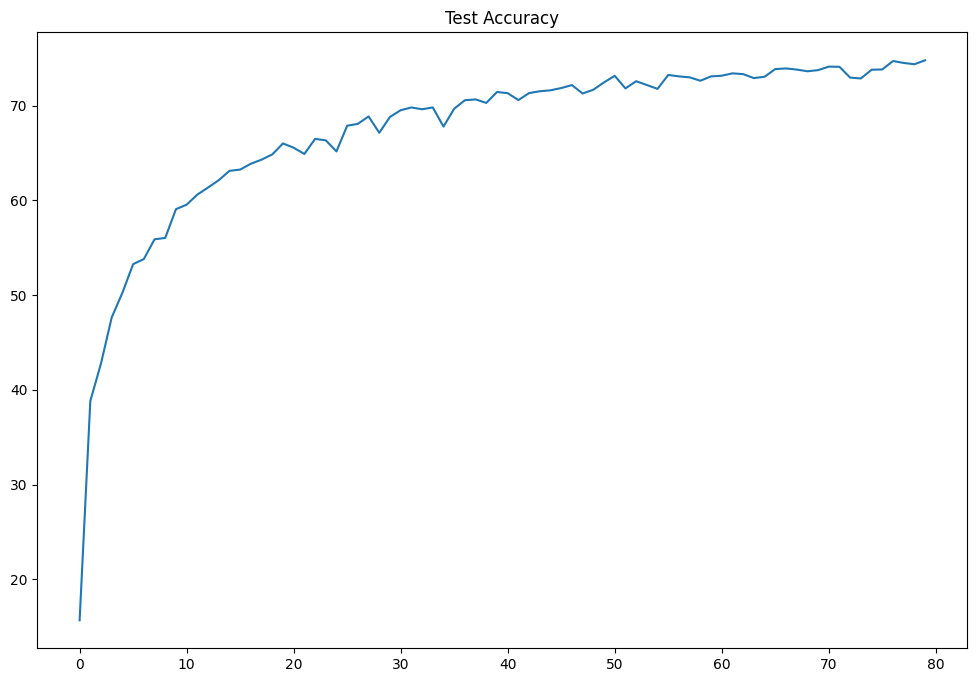

In [51]:
df = pd.DataFrame()
df['base-loss'] = train_loss
df['base-acc'] = test_right
plt.figure(figsize = (12, 8))
plt.plot(df['base-acc'])
plt.title('Test Accuracy')
plt.show()

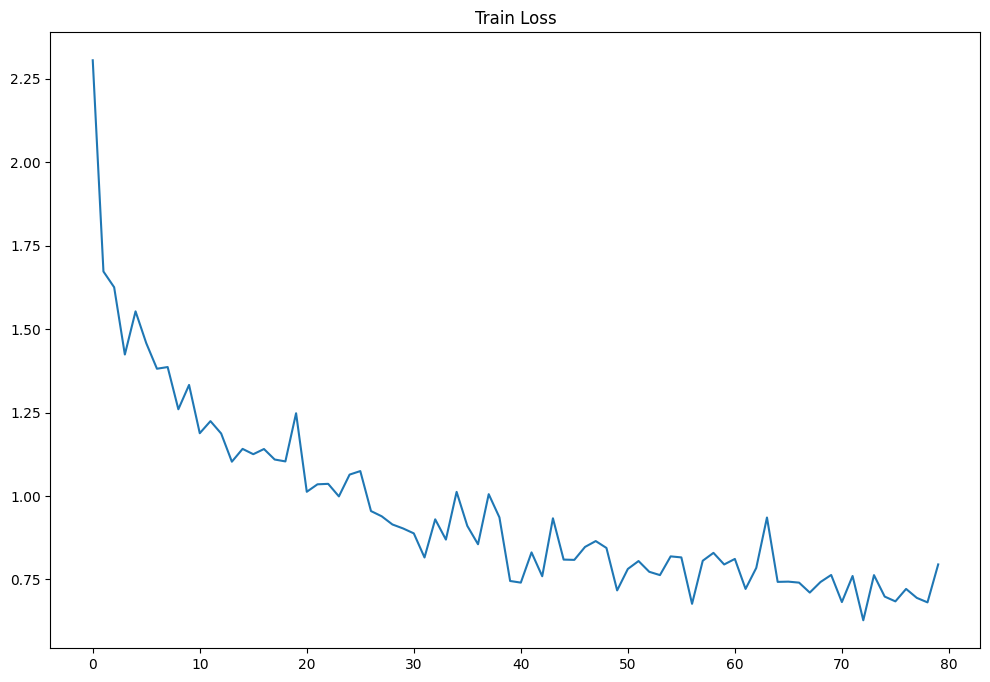

In [52]:
plt.figure(figsize = (12, 8))
plt.plot(df['base-loss'])
plt.title('Train Loss')
plt.show()

In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
class Model_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=3,
                                             out_channels=32,
                                             kernel_size=5,
                                             stride=1,
                                             padding=2),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2),)
        self.conv2 = nn.Sequential(nn.Conv2d(32, 64, 5, 1, 2),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2),)
        self.dropout = nn.Dropout(p=0.5)  # 添加dropout层
        self.out = nn.Sequential(nn.Flatten(),
                                 nn.Linear(64 * 8 * 8, 256),
                                 nn.ReLU(),
                                 self.dropout,  # 在输出层前添加dropout层
                                 nn.Linear(256, 10),)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.dropout(x)  # 在中间层之间添加dropout层
        output = self.out(x)
        return output

class Model_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=3,
                                             out_channels=32,
                                             kernel_size=5,
                                             stride=1,
                                             padding=2),
                                   nn.Sigmoid(),
                                   nn.MaxPool2d(2),)
        self.conv2 = nn.Sequential(nn.Conv2d(32, 64, 5, 1, 2),
                                   nn.Sigmoid(),
                                   nn.MaxPool2d(2),)
        self.dropout = nn.Dropout(p=0.5)  # 添加dropout层
        self.out = nn.Sequential(nn.Flatten(),
                                 nn.Linear(64 * 8 * 8, 256),
                                 nn.Sigmoid(),
                                 self.dropout,  # 在输出层前添加dropout层
                                 nn.Linear(256, 10),)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.dropout(x)  # 在中间层之间添加dropout层
        output = self.out(x)
        return output


class Model_3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=3,
                                             out_channels=32,
                                             kernel_size=5,
                                             stride=1,
                                             padding=2),
                                   nn.Tanh(),
                                   nn.MaxPool2d(2),)
        self.conv2 = nn.Sequential(nn.Conv2d(32, 64, 5, 1, 2),
                                   nn.Tanh(),
                                   nn.MaxPool2d(2),)
        self.dropout = nn.Dropout(p=0.5)  # 添加dropout层
        self.out = nn.Sequential(nn.Flatten(),
                                 nn.Linear(64 * 8 * 8, 256),
                                 nn.Tanh(),
                                 self.dropout,  # 在输出层前添加dropout层
                                 nn.Linear(256, 10),)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.dropout(x)  # 在中间层之间添加dropout层
        output = self.out(x)
        return output
    
class Model_4(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=3,
                                             out_channels=32,
                                             kernel_size=5,
                                             stride=1,
                                             padding=2),
                                   nn.LeakyReLU(),
                                   nn.MaxPool2d(2),)
        self.conv2 = nn.Sequential(nn.Conv2d(32, 64, 5, 1, 2),
                                   nn.LeakyReLU(),
                                   nn.MaxPool2d(2),)
        self.dropout = nn.Dropout(p=0.5)  # 添加dropout层
        self.out = nn.Sequential(nn.Flatten(),
                                 nn.Linear(64 * 8 * 8, 256),
                                 nn.LeakyReLU(),
                                 self.dropout,  # 在输出层前添加dropout层
                                 nn.Linear(256, 10),)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.dropout(x)  # 在中间层之间添加dropout层
        output = self.out(x)
        return output

In [54]:
def train_test(a):
    #定义准确率作为评估标准
    def accuracy(predictions, labels):
        pred = torch.max(predictions.data, 1)[1]            #torch.max()[0]返回最大值 torch.max()[1]返回最大值位置，既预测值
        rights = pred.eq(labels.data.view_as(pred)).sum()
        return rights, len(labels)
    models = [Model_1(), Model_2(), Model_3(), Model_4()]
    net = models[a]
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    net.cuda()
    test_right = []
    train_loss = []

    for epoch in range(num_epochs):
        train_rights = []
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.cuda(), target.cuda()
            net.train()
            output = net(data)
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            right = accuracy(output, target)
            train_rights.append(right)
            
            if batch_idx % 50 == 0:
                net.eval()
                val_rights = []
                
                for (data, target) in test_loader:
                    data, target = data.cuda(), target.cuda()
                    output = net(data)
                    right = accuracy(output, target)
                    val_rights.append(right)
                
                train_r = (sum([tup[0] for tup in train_rights]), sum([tup[1] for tup in train_rights]))
                val_r = (sum([tup[0] for tup in val_rights]), sum([tup[1] for tup in val_rights]))
                test_right.append((100*val_r[0]/val_r[1]).cpu().numpy())
                train_loss.append(loss.data.cpu().numpy())
                print(f'当前epoch:{epoch + 1} [{batch_idx*batch_size}/{len(train_loader.dataset)}]   \
                    损失：{loss.data:.6f}  训练集准确率：{100*train_r[0]/train_r[1]:.2f}%   测试集准确率：{100*val_r[0]/val_r[1]:.2f}%')
    return test_right, train_loss

In [55]:
test_right, train_loss = train_test(0)
df['ReLu-acc'] = test_right
df['ReLu-loss'] = train_loss

当前epoch:1 [0/50000]                       损失：2.303528  训练集准确率：8.59%   测试集准确率：12.10%
当前epoch:1 [12800/50000]                       损失：1.804210  训练集准确率：25.80%   测试集准确率：36.70%
当前epoch:1 [25600/50000]                       损失：1.765708  训练集准确率：31.09%   测试集准确率：43.73%
当前epoch:1 [38400/50000]                       损失：1.568422  训练集准确率：34.59%   测试集准确率：47.62%
当前epoch:2 [0/50000]                       损失：1.562357  训练集准确率：44.92%   测试集准确率：47.37%
当前epoch:2 [12800/50000]                       损失：1.450628  训练集准确率：46.75%   测试集准确率：51.53%
当前epoch:2 [25600/50000]                       损失：1.387761  训练集准确率：47.83%   测试集准确率：53.56%
当前epoch:2 [38400/50000]                       损失：1.350464  训练集准确率：48.77%   测试集准确率：54.59%
当前epoch:3 [0/50000]                       损失：1.256543  训练集准确率：54.30%   测试集准确率：55.45%
当前epoch:3 [12800/50000]                       损失：1.309550  训练集准确率：53.22%   测试集准确率：56.18%
当前epoch:3 [25600/50000]                       损失：1.270952  训练集准确率：53.75%   测试集准确率：58.15%
当前epoch:3 [38400/50000]           

In [56]:
test_right, train_loss = train_test(1)
df['Sigmoid-acc'] = test_right
df['Sigmoid-loss'] = train_loss

当前epoch:1 [0/50000]                       损失：2.334844  训练集准确率：10.16%   测试集准确率：10.00%
当前epoch:1 [12800/50000]                       损失：2.319303  训练集准确率：10.09%   测试集准确率：10.01%
当前epoch:1 [25600/50000]                       损失：2.277998  训练集准确率：11.44%   测试集准确率：22.77%
当前epoch:1 [38400/50000]                       损失：2.095267  训练集准确率：13.77%   测试集准确率：24.88%
当前epoch:2 [0/50000]                       损失：1.983416  训练集准确率：26.17%   测试集准确率：26.95%
当前epoch:2 [12800/50000]                       损失：2.014563  训练集准确率：25.77%   测试集准确率：28.73%
当前epoch:2 [25600/50000]                       损失：1.934102  训练集准确率：26.32%   测试集准确率：29.27%
当前epoch:2 [38400/50000]                       损失：1.995314  训练集准确率：26.70%   测试集准确率：30.40%
当前epoch:3 [0/50000]                       损失：1.927925  训练集准确率：32.81%   测试集准确率：32.26%
当前epoch:3 [12800/50000]                       损失：1.921764  训练集准确率：30.49%   测试集准确率：33.76%
当前epoch:3 [25600/50000]                       损失：1.874724  训练集准确率：31.60%   测试集准确率：35.15%
当前epoch:3 [38400/50000]          

In [57]:
test_right, train_loss = train_test(2)
df['Tanh-acc'] = test_right
df['Tanh-loss'] = train_loss

当前epoch:1 [0/50000]                       损失：2.307829  训练集准确率：10.55%   测试集准确率：11.97%
当前epoch:1 [12800/50000]                       损失：1.701704  训练集准确率：32.80%   测试集准确率：42.25%
当前epoch:1 [25600/50000]                       损失：1.573824  训练集准确率：38.06%   测试集准确率：48.78%
当前epoch:1 [38400/50000]                       损失：1.518231  训练集准确率：41.31%   测试集准确率：50.60%
当前epoch:2 [0/50000]                       损失：1.423695  训练集准确率：53.52%   测试集准确率：53.05%
当前epoch:2 [12800/50000]                       损失：1.394256  训练集准确率：51.78%   测试集准确率：55.92%
当前epoch:2 [25600/50000]                       损失：1.212157  训练集准确率：52.92%   测试集准确率：56.74%
当前epoch:2 [38400/50000]                       损失：1.188578  训练集准确率：53.56%   测试集准确率：57.98%
当前epoch:3 [0/50000]                       损失：1.288036  训练集准确率：52.34%   测试集准确率：58.09%
当前epoch:3 [12800/50000]                       损失：1.209541  训练集准确率：56.92%   测试集准确率：61.10%
当前epoch:3 [25600/50000]                       损失：1.299054  训练集准确率：57.60%   测试集准确率：58.60%
当前epoch:3 [38400/50000]          

In [58]:
test_right, train_loss = train_test(3)
df['LeakyReLu-acc'] = test_right
df['LeakyReLu-loss'] = train_loss

当前epoch:1 [0/50000]                       损失：2.316029  训练集准确率：7.42%   测试集准确率：10.00%
当前epoch:1 [12800/50000]                       损失：1.731661  训练集准确率：25.62%   测试集准确率：38.53%
当前epoch:1 [25600/50000]                       损失：1.734107  训练集准确率：31.45%   测试集准确率：42.35%
当前epoch:1 [38400/50000]                       损失：1.535982  训练集准确率：34.58%   测试集准确率：45.87%
当前epoch:2 [0/50000]                       损失：1.625551  训练集准确率：42.97%   测试集准确率：48.65%
当前epoch:2 [12800/50000]                       损失：1.392880  训练集准确率：47.18%   测试集准确率：50.35%
当前epoch:2 [25600/50000]                       损失：1.483091  训练集准确率：48.59%   测试集准确率：54.26%
当前epoch:2 [38400/50000]                       损失：1.350613  训练集准确率：49.58%   测试集准确率：55.15%
当前epoch:3 [0/50000]                       损失：1.385733  训练集准确率：50.78%   测试集准确率：56.61%
当前epoch:3 [12800/50000]                       损失：1.203781  训练集准确率：54.57%   测试集准确率：58.57%
当前epoch:3 [25600/50000]                       损失：1.220030  训练集准确率：54.55%   测试集准确率：60.55%
当前epoch:3 [38400/50000]           

In [59]:
df

,base-loss,base-acc,ReLu-acc,ReLu-loss,Sigmoid-acc,Sigmoid-loss,Tanh-acc,Tanh-loss,LeakyReLu-acc,LeakyReLu-loss
0,2.3050797,15.679999,12.099999,2.3035283,10.0,2.3348436,11.969999,2.3078287,10.0,2.3160293
1,1.6723946,38.829998,36.7,1.8042097,10.009999,2.319303,42.25,1.7017035,38.53,1.7316606
2,1.6251671,42.8,43.73,1.7657076,22.769999,2.2779984,48.78,1.5738242,42.35,1.7341067
3,1.4236944,47.649998,47.62,1.5684221,24.88,2.0952673,50.6,1.5182312,45.87,1.5359819
4,1.5529698,50.26,47.37,1.5623573,26.949999,1.9834163,53.05,1.4236951,48.649998,1.6255507
...,...,...,...,...,...,...,...,...,...,...
75,0.6842479,73.82,74.36,0.73001474,57.02,1.2048417,68.689995,0.8536566,75.08,0.6168025
76,0.72153044,74.71,73.479996,0.70796096,56.969997,1.3185892,70.869995,0.8066182,73.34,0.6673581
77,0.6947372,74.509995,73.4,0.66758436,57.309998,1.2566977,71.17,0.8207205,75.15,0.6528687
78,0.6812734,74.369995,74.45,0.6424976,57.649998,1.1645101,70.63,0.80494565,73.89,0.6270602


Text(0.5, 1.0, 'Test Accuracy')

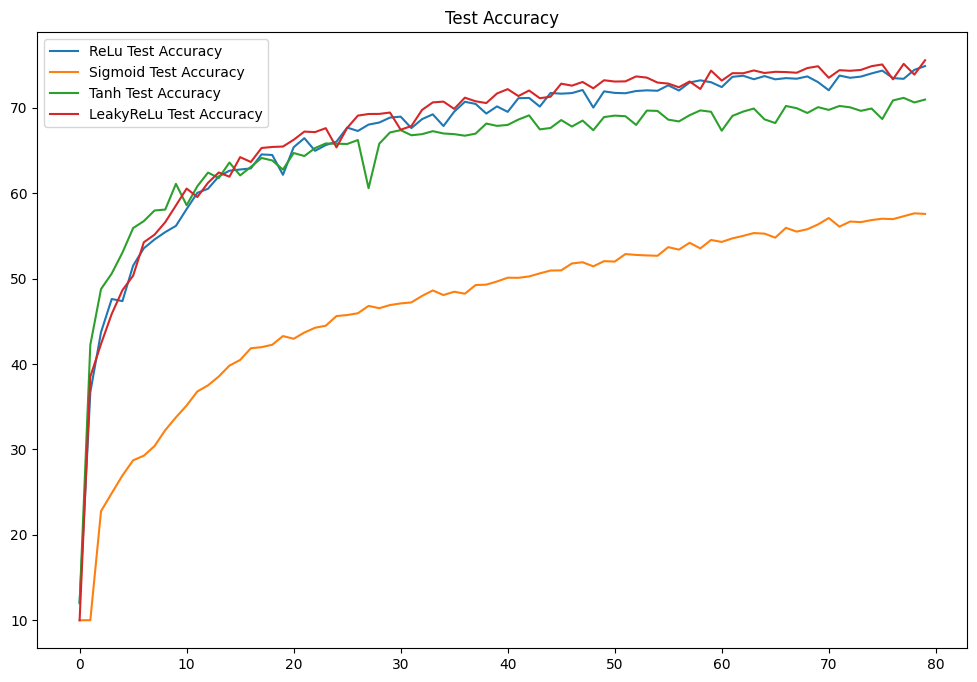

In [60]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12, 8))
plt.plot(df['ReLu-acc'], label = 'ReLu Test Accuracy')
plt.plot(df['Sigmoid-acc'], label = 'Sigmoid Test Accuracy')
plt.plot(df['Tanh-acc'], label = 'Tanh Test Accuracy')
plt.plot(df['LeakyReLu-acc'], label = 'LeakyReLu Test Accuracy')
plt.legend()
plt.title('Test Accuracy')

Text(0.5, 1.0, 'Train Loss')

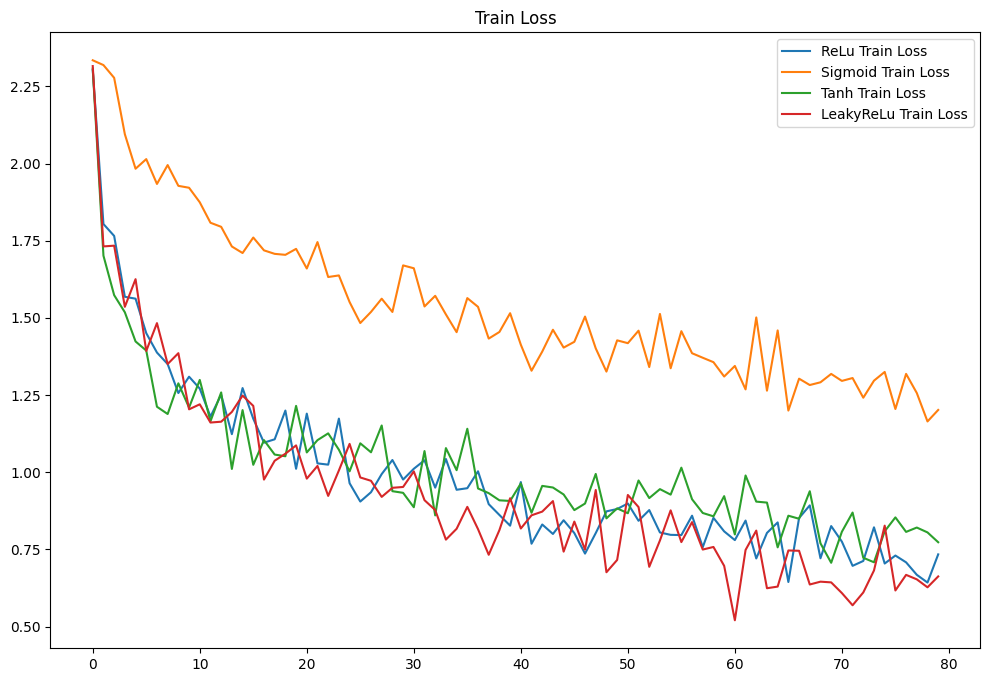

In [61]:
plt.figure(figsize = (12, 8))
plt.plot(df['ReLu-loss'], label = 'ReLu Train Loss')
plt.plot(df['Sigmoid-loss'], label = 'Sigmoid Train Loss')
plt.plot(df['Tanh-loss'], label = 'Tanh Train Loss')
plt.plot(df['LeakyReLu-loss'], label = 'LeakyReLu Train Loss')
plt.legend()
plt.title('Train Loss')

不同通道

In [83]:
class Model_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=3,
                                             out_channels=16,
                                             kernel_size=5,
                                             stride=1,
                                             padding=2),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2),)
        self.conv2 = nn.Sequential(nn.Conv2d(16, 32, 5, 1, 2),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2),)
        self.dropout = nn.Dropout(p=0.5)  # 添加dropout层
        self.out = nn.Sequential(nn.Flatten(),
                                 nn.Linear(32 * 8 * 8, 256),
                                 nn.ReLU(),
                                 self.dropout,  # 在输出层前添加dropout层
                                 nn.Linear(256, 10),)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.dropout(x)  # 在中间层之间添加dropout层
        output = self.out(x)
        return output
    
class Model_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=3,
                                             out_channels=32,
                                             kernel_size=5,
                                             stride=1,
                                             padding=2),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2),)
        self.conv2 = nn.Sequential(nn.Conv2d(32, 64, 5, 1, 2),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2),)
        self.dropout = nn.Dropout(p=0.5)  # 添加dropout层
        self.out = nn.Sequential(nn.Flatten(),
                                 nn.Linear(64 * 8 * 8, 256),
                                 nn.ReLU(),
                                 self.dropout,  # 在输出层前添加dropout层
                                 nn.Linear(256, 10),)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.dropout(x)  # 在中间层之间添加dropout层
        output = self.out(x)
        return output

class Model_3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=3,
                                             out_channels=64,  # Changed to 64
                                             kernel_size=5,
                                             stride=1,
                                             padding=2),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2),)
        self.conv2 = nn.Sequential(nn.Conv2d(64, 64, 5, 1, 2),  # Changed to 64
                                   nn.ReLU(),
                                   nn.MaxPool2d(2),)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sequential(nn.Flatten(),
                                 nn.Linear(64 * 8 * 8, 256),  # Updated input size based on out_channels
                                 nn.ReLU(),
                                 self.dropout,
                                 nn.Linear(256, 10),)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.dropout(x)
        output = self.out(x)
        return output

In [84]:
def train_test(a):
    #定义准确率作为评估标准
    def accuracy(predictions, labels):
        pred = torch.max(predictions.data, 1)[1]            #torch.max()[0]返回最大值 torch.max()[1]返回最大值位置，既预测值
        rights = pred.eq(labels.data.view_as(pred)).sum()
        return rights, len(labels) 
    models = [Model_1(), Model_2(), Model_3()]
    net = models[a]
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    net.cuda()
    test_right = []
    train_loss = []

    for epoch in range(num_epochs):
        train_rights = []
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.cuda(), target.cuda()
            net.train()
            output = net(data)
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            right = accuracy(output, target)
            train_rights.append(right)
            
            if batch_idx % 50 == 0:
                net.eval()
                val_rights = []
                
                for (data, target) in test_loader:
                    data, target = data.cuda(), target.cuda()
                    output = net(data)
                    right = accuracy(output, target)
                    val_rights.append(right)
                
                train_r = (sum([tup[0] for tup in train_rights]), sum([tup[1] for tup in train_rights]))
                val_r = (sum([tup[0] for tup in val_rights]), sum([tup[1] for tup in val_rights]))
                test_right.append((100*val_r[0]/val_r[1]).cpu().numpy())
                train_loss.append(loss.data.cpu().numpy())
                print(f'当前epoch:{epoch + 1} [{batch_idx*batch_size}/{len(train_loader.dataset)}]   \
                    损失：{loss.data:.6f}  训练集准确率：{100*train_r[0]/train_r[1]:.2f}%   测试集准确率：{100*val_r[0]/val_r[1]:.2f}%')
    return test_right, train_loss

In [87]:
test_right, train_loss = train_test(0)
df['out16-acc'] = test_right
df['out16-loss'] = train_loss

当前epoch:1 [0/50000]                       损失：2.309566  训练集准确率：9.77%   测试集准确率：10.00%
当前epoch:1 [12800/50000]                       损失：1.901310  训练集准确率：22.24%   测试集准确率：35.45%
当前epoch:1 [25600/50000]                       损失：1.790761  训练集准确率：28.21%   测试集准确率：40.85%
当前epoch:1 [38400/50000]                       损失：1.473706  训练集准确率：31.75%   测试集准确率：43.90%
当前epoch:2 [0/50000]                       损失：1.567808  训练集准确率：40.62%   测试集准确率：46.15%
当前epoch:2 [12800/50000]                       损失：1.517869  训练集准确率：42.85%   测试集准确率：47.77%
当前epoch:2 [25600/50000]                       损失：1.470593  训练集准确率：43.72%   测试集准确率：49.44%
当前epoch:2 [38400/50000]                       损失：1.467031  训练集准确率：45.06%   测试集准确率：51.55%
当前epoch:3 [0/50000]                       损失：1.566693  训练集准确率：45.31%   测试集准确率：51.09%
当前epoch:3 [12800/50000]                       损失：1.340467  训练集准确率：49.59%   测试集准确率：53.23%
当前epoch:3 [25600/50000]                       损失：1.403997  训练集准确率：49.39%   测试集准确率：52.03%
当前epoch:3 [38400/50000]           

In [88]:
test_right, train_loss = train_test(1)
df['out32-acc'] = test_right
df['out32-loss'] = train_loss

当前epoch:1 [0/50000]                       损失：2.303292  训练集准确率：11.33%   测试集准确率：10.03%
当前epoch:1 [12800/50000]                       损失：1.773600  训练集准确率：24.62%   测试集准确率：36.93%
当前epoch:1 [25600/50000]                       损失：1.622776  训练集准确率：31.10%   测试集准确率：44.05%
当前epoch:1 [38400/50000]                       损失：1.532637  训练集准确率：34.61%   测试集准确率：46.59%
当前epoch:2 [0/50000]                       损失：1.486129  训练集准确率：48.44%   测试集准确率：49.95%
当前epoch:2 [12800/50000]                       损失：1.327166  训练集准确率：47.08%   测试集准确率：51.89%
当前epoch:2 [25600/50000]                       损失：1.359451  训练集准确率：48.08%   测试集准确率：53.92%
当前epoch:2 [38400/50000]                       损失：1.397236  训练集准确率：48.68%   测试集准确率：52.53%
当前epoch:3 [0/50000]                       损失：1.353150  训练集准确率：46.09%   测试集准确率：54.96%
当前epoch:3 [12800/50000]                       损失：1.271523  训练集准确率：52.90%   测试集准确率：55.51%
当前epoch:3 [25600/50000]                       损失：1.429943  训练集准确率：53.23%   测试集准确率：56.71%
当前epoch:3 [38400/50000]          

In [89]:
test_right, train_loss = train_test(2)
df['out64-acc'] = test_right
df['out64-loss'] = train_loss

当前epoch:1 [0/50000]                       损失：2.309986  训练集准确率：8.59%   测试集准确率：10.21%
当前epoch:1 [12800/50000]                       损失：1.849226  训练集准确率：25.83%   测试集准确率：39.96%
当前epoch:1 [25600/50000]                       损失：1.581208  训练集准确率：32.15%   测试集准确率：44.97%
当前epoch:1 [38400/50000]                       损失：1.607641  训练集准确率：35.85%   测试集准确率：49.07%
当前epoch:2 [0/50000]                       损失：1.510379  训练集准确率：44.92%   测试集准确率：51.30%
当前epoch:2 [12800/50000]                       损失：1.406928  训练集准确率：47.46%   测试集准确率：51.93%
当前epoch:2 [25600/50000]                       损失：1.468648  训练集准确率：48.27%   测试集准确率：54.09%
当前epoch:2 [38400/50000]                       损失：1.338574  训练集准确率：49.31%   测试集准确率：56.10%
当前epoch:3 [0/50000]                       损失：1.288979  训练集准确率：55.86%   测试集准确率：58.21%
当前epoch:3 [12800/50000]                       损失：1.179108  训练集准确率：54.18%   测试集准确率：58.22%
当前epoch:3 [25600/50000]                       损失：1.339443  训练集准确率：54.32%   测试集准确率：60.18%
当前epoch:3 [38400/50000]           

In [90]:
df

,base-loss,base-acc,ReLu-acc,ReLu-loss,Sigmoid-acc,Sigmoid-loss,Tanh-acc,Tanh-loss,LeakyReLu-acc,LeakyReLu-loss,out16-acc,out16-loss,out32-acc,out32-loss,out64-acc,out64-loss
0,2.3050797,15.679999,12.099999,2.3035283,10.0,2.3348436,11.969999,2.3078287,10.0,2.3160293,10.0,2.309566,10.03,2.303292,10.21,2.3099864
1,1.6723946,38.829998,36.7,1.8042097,10.009999,2.319303,42.25,1.7017035,38.53,1.7316606,35.45,1.9013103,36.93,1.7736001,39.96,1.8492259
2,1.6251671,42.8,43.73,1.7657076,22.769999,2.2779984,48.78,1.5738242,42.35,1.7341067,40.85,1.7907612,44.05,1.6227763,44.969997,1.5812085
3,1.4236944,47.649998,47.62,1.5684221,24.88,2.0952673,50.6,1.5182312,45.87,1.5359819,43.899998,1.4737064,46.59,1.5326374,49.07,1.6076407
4,1.5529698,50.26,47.37,1.5623573,26.949999,1.9834163,53.05,1.4236951,48.649998,1.6255507,46.149998,1.5678079,49.949997,1.4861286,51.3,1.510379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.6842479,73.82,74.36,0.73001474,57.02,1.2048417,68.689995,0.8536566,75.08,0.6168025,69.78,0.9114673,72.86,0.83169097,74.29,0.77158904
76,0.72153044,74.71,73.479996,0.70796096,56.969997,1.3185892,70.869995,0.8066182,73.34,0.6673581,69.56,0.98274606,72.619995,0.8306993,74.97,0.85269094
77,0.6947372,74.509995,73.4,0.66758436,57.309998,1.2566977,71.17,0.8207205,75.15,0.6528687,69.99,0.91209805,73.159996,0.90571827,74.71,0.7983222
78,0.6812734,74.369995,74.45,0.6424976,57.649998,1.1645101,70.63,0.80494565,73.89,0.6270602,69.7,0.9242427,72.759995,0.79537183,74.36,0.70632


Text(0.5, 1.0, 'Test Accuracy')

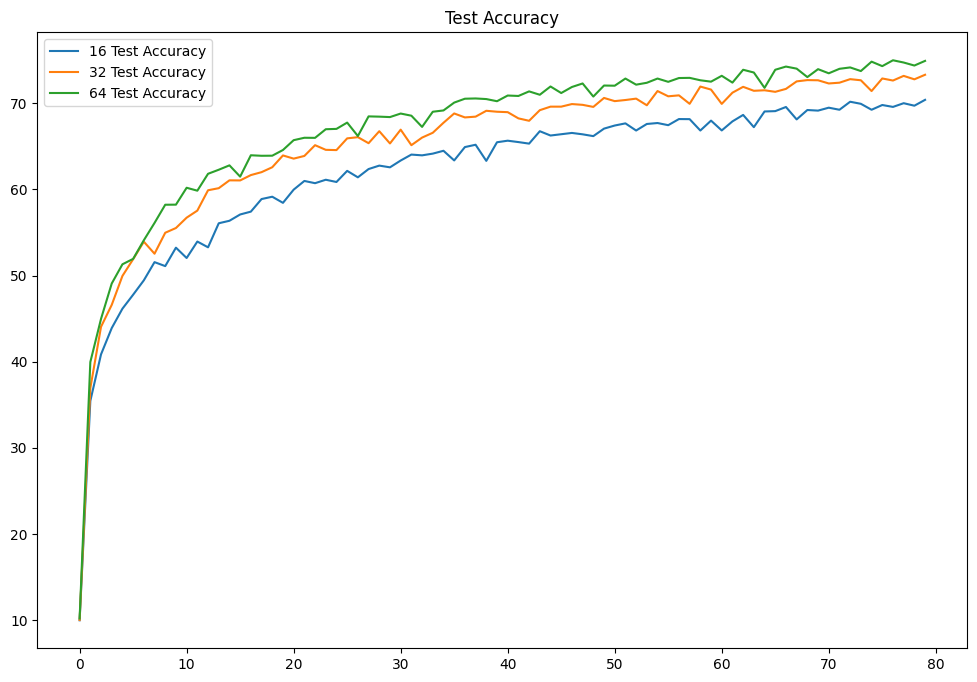

In [91]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12, 8))
plt.plot(df['out16-acc'], label = '16 Test Accuracy')
plt.plot(df['out32-acc'], label = '32 Test Accuracy')
plt.plot(df['out64-acc'], label = '64 Test Accuracy')
plt.legend()
plt.title('Test Accuracy')

Text(0.5, 1.0, 'Train Loss')

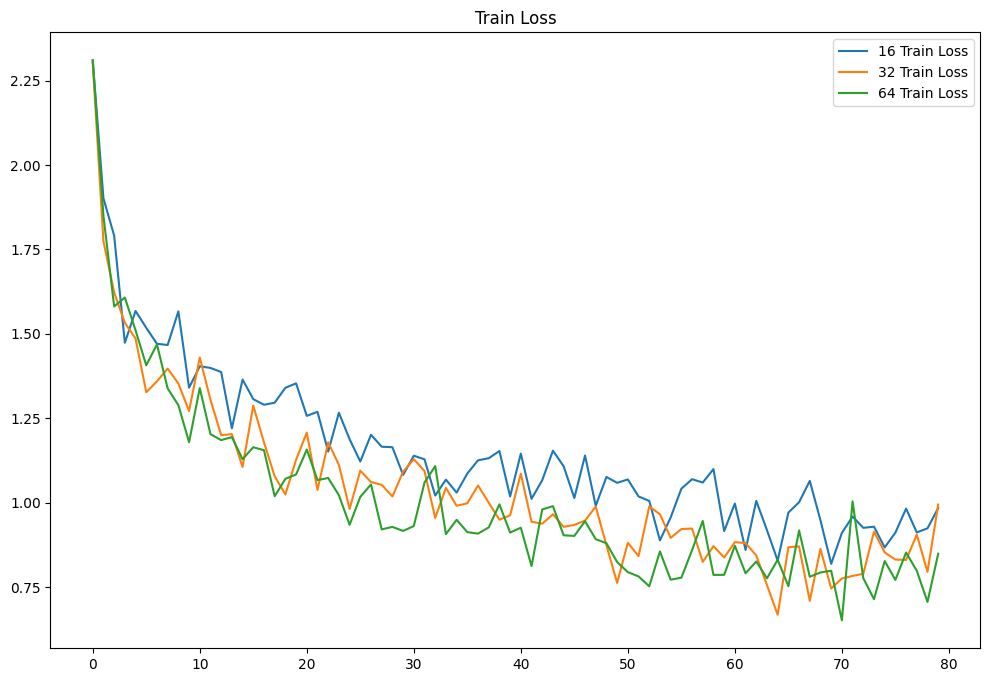

In [92]:
plt.figure(figsize = (12, 8))
plt.plot(df['out16-loss'], label = '16 Train Loss')
plt.plot(df['out32-loss'], label = '32 Train Loss')
plt.plot(df['out64-loss'], label = '64 Train Loss')
plt.legend()
plt.title('Train Loss')

卷积层数量

In [93]:
class Model_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=3,
                                             out_channels=64,  # 修改为64
                                             kernel_size=5,
                                             stride=1,
                                             padding=2),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2),)
        self.dropout = nn.Dropout(p=0.5)  # 添加dropout层
        self.out = nn.Sequential(nn.Flatten(),
                                 nn.Linear(64 * 16 * 16, 256),
                                 nn.ReLU(),
                                 self.dropout,  # 在输出层前添加dropout层
                                 nn.Linear(256, 10),)

    def forward(self, x):
        x = self.conv1(x)
        x = self.dropout(x)  # 在中间层之间添加dropout层
        output = self.out(x)
        return output


class Model_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=3,
                                             out_channels=64,
                                             kernel_size=5,
                                             stride=1,
                                             padding=2),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2),)
        self.conv2 = nn.Sequential(nn.Conv2d(64, 128, 5, 1, 2),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2),)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sequential(nn.Flatten(),
                                 nn.Linear(128 * 8 * 8, 256),  # 将输入通道数改为 128，计算输出尺寸为 8 * 8
                                 nn.ReLU(),
                                 self.dropout,
                                 nn.Linear(256, 10),)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.dropout(x)
        output = self.out(x)
        return output


class Model_3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=3,
                                             out_channels=64,  # 将 out_channels 改为 64
                                             kernel_size=5,
                                             stride=1,
                                             padding=2),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2),)
        self.conv2 = nn.Sequential(nn.Conv2d(64, 32, 5, 1, 2),  # 修改输入通道数为 64
                                   nn.ReLU(),
                                   nn.MaxPool2d(2),)
        self.conv3 = nn.Sequential(nn.Conv2d(32, 64, 5, 1, 2),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2),)
        self.dropout = nn.Dropout(p=0.5)  # 添加dropout层
        self.out = nn.Sequential(nn.Flatten(),
                                 nn.Linear(64 * 4 * 4, 256),
                                 nn.ReLU(),
                                 self.dropout,  # 在输出层前添加dropout层
                                 nn.Linear(256, 10),)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.dropout(x)  # 在中间层之间添加dropout层
        output = self.out(x)
        return output

In [94]:
def train_test(a):
    #定义准确率作为评估标准
    def accuracy(predictions, labels):
        pred = torch.max(predictions.data, 1)[1]            #torch.max()[0]返回最大值 torch.max()[1]返回最大值位置，既预测值
        rights = pred.eq(labels.data.view_as(pred)).sum()
        return rights, len(labels) 
    models = [Model_1(), Model_2(), Model_3()]
    net = models[a]
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    net.cuda()
    test_right = []
    train_loss = []

    for epoch in range(num_epochs):
        train_rights = []
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.cuda(), target.cuda()
            net.train()
            output = net(data)
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            right = accuracy(output, target)
            train_rights.append(right)
            
            if batch_idx % 50 == 0:
                net.eval()
                val_rights = []
                
                for (data, target) in test_loader:
                    data, target = data.cuda(), target.cuda()
                    output = net(data)
                    right = accuracy(output, target)
                    val_rights.append(right)
                
                train_r = (sum([tup[0] for tup in train_rights]), sum([tup[1] for tup in train_rights]))
                val_r = (sum([tup[0] for tup in val_rights]), sum([tup[1] for tup in val_rights]))
                test_right.append((100*val_r[0]/val_r[1]).cpu().numpy())
                train_loss.append(loss.data.cpu().numpy())
                print(f'当前epoch:{epoch} [{batch_idx*batch_size}/{len(train_loader.dataset)}]   \
                    损失：{loss.data:.6f}  训练集准确率：{100*train_r[0]/train_r[1]:.2f}%   测试集准确率：{100*val_r[0]/val_r[1]:.2f}%')
    return test_right, train_loss

In [95]:
test_right, train_loss = train_test(0)
df['卷积层1-acc'] = test_right
df['卷积层1-loss'] = train_loss

当前epoch:0 [0/50000]                       损失：2.305776  训练集准确率：11.33%   测试集准确率：10.00%
当前epoch:0 [12800/50000]                       损失：1.985750  训练集准确率：17.33%   测试集准确率：28.25%
当前epoch:0 [25600/50000]                       损失：1.824475  训练集准确率：23.26%   测试集准确率：38.20%
当前epoch:0 [38400/50000]                       损失：1.718179  训练集准确率：26.82%   测试集准确率：42.28%
当前epoch:1 [0/50000]                       损失：1.632678  训练集准确率：43.75%   测试集准确率：44.56%
当前epoch:1 [12800/50000]                       损失：1.582083  训练集准确率：39.99%   测试集准确率：47.70%
当前epoch:1 [25600/50000]                       损失：1.591293  训练集准确率：41.02%   测试集准确率：48.57%
当前epoch:1 [38400/50000]                       损失：1.518571  训练集准确率：41.63%   测试集准确率：49.66%
当前epoch:2 [0/50000]                       损失：1.568986  训练集准确率：42.58%   测试集准确率：51.20%
当前epoch:2 [12800/50000]                       损失：1.444148  训练集准确率：44.89%   测试集准确率：51.95%
当前epoch:2 [25600/50000]                       损失：1.345037  训练集准确率：45.74%   测试集准确率：51.76%
当前epoch:2 [38400/50000]          

In [96]:
test_right, train_loss = train_test(1)
df['卷积层2-acc'] = test_right
df['卷积层2-loss'] = train_loss

当前epoch:0 [0/50000]                       损失：2.309981  训练集准确率：10.55%   测试集准确率：10.36%
当前epoch:0 [12800/50000]                       损失：1.715766  训练集准确率：27.14%   测试集准确率：39.52%
当前epoch:0 [25600/50000]                       损失：1.559140  训练集准确率：33.54%   测试集准确率：45.26%
当前epoch:0 [38400/50000]                       损失：1.507572  训练集准确率：36.42%   测试集准确率：46.56%
当前epoch:1 [0/50000]                       损失：1.432557  训练集准确率：47.66%   测试集准确率：51.72%
当前epoch:1 [12800/50000]                       损失：1.339304  训练集准确率：49.36%   测试集准确率：53.40%
当前epoch:1 [25600/50000]                       损失：1.317939  训练集准确率：49.90%   测试集准确率：54.22%
当前epoch:1 [38400/50000]                       损失：1.503317  训练集准确率：50.53%   测试集准确率：57.39%
当前epoch:2 [0/50000]                       损失：1.420254  训练集准确率：51.17%   测试集准确率：56.32%
当前epoch:2 [12800/50000]                       损失：1.321827  训练集准确率：54.36%   测试集准确率：58.40%
当前epoch:2 [25600/50000]                       损失：1.243469  训练集准确率：55.24%   测试集准确率：58.36%
当前epoch:2 [38400/50000]          

In [97]:
test_right, train_loss = train_test(2)
df['卷积层3-acc'] = test_right
df['卷积层3-loss'] = train_loss

当前epoch:0 [0/50000]                       损失：2.304450  训练集准确率：7.42%   测试集准确率：7.65%
当前epoch:0 [12800/50000]                       损失：1.879641  训练集准确率：20.01%   测试集准确率：33.05%
当前epoch:0 [25600/50000]                       损失：1.749141  训练集准确率：26.10%   测试集准确率：39.10%
当前epoch:0 [38400/50000]                       损失：1.589149  训练集准确率：29.97%   测试集准确率：41.80%
当前epoch:1 [0/50000]                       损失：1.524964  训练集准确率：44.92%   测试集准确率：45.51%
当前epoch:1 [12800/50000]                       损失：1.537417  训练集准确率：44.46%   测试集准确率：49.04%
当前epoch:1 [25600/50000]                       损失：1.464624  训练集准确率：45.04%   测试集准确率：50.89%
当前epoch:1 [38400/50000]                       损失：1.379284  训练集准确率：45.71%   测试集准确率：52.77%
当前epoch:2 [0/50000]                       损失：1.367056  训练集准确率：50.78%   测试集准确率：52.01%
当前epoch:2 [12800/50000]                       损失：1.369258  训练集准确率：50.83%   测试集准确率：53.85%
当前epoch:2 [25600/50000]                       损失：1.303673  训练集准确率：51.39%   测试集准确率：56.45%
当前epoch:2 [38400/50000]            

In [99]:
df

,base-loss,base-acc,ReLu-acc,ReLu-loss,Sigmoid-acc,Sigmoid-loss,Tanh-acc,Tanh-loss,LeakyReLu-acc,LeakyReLu-loss,...,out32-acc,out32-loss,out64-acc,out64-loss,卷积层1-acc,卷积层1-loss,卷积层2-acc,卷积层2-loss,卷积层3-acc,卷积层3-loss
0,2.3050797,15.679999,12.099999,2.3035283,10.0,2.3348436,11.969999,2.3078287,10.0,2.3160293,...,10.03,2.303292,10.21,2.3099864,10.0,2.3057764,10.36,2.3099813,7.6499996,2.3044503
1,1.6723946,38.829998,36.7,1.8042097,10.009999,2.319303,42.25,1.7017035,38.53,1.7316606,...,36.93,1.7736001,39.96,1.8492259,28.25,1.98575,39.52,1.7157662,33.05,1.8796414
2,1.6251671,42.8,43.73,1.7657076,22.769999,2.2779984,48.78,1.5738242,42.35,1.7341067,...,44.05,1.6227763,44.969997,1.5812085,38.2,1.824475,45.26,1.5591398,39.1,1.7491406
3,1.4236944,47.649998,47.62,1.5684221,24.88,2.0952673,50.6,1.5182312,45.87,1.5359819,...,46.59,1.5326374,49.07,1.6076407,42.28,1.7181795,46.559998,1.5075716,41.8,1.5891492
4,1.5529698,50.26,47.37,1.5623573,26.949999,1.9834163,53.05,1.4236951,48.649998,1.6255507,...,49.949997,1.4861286,51.3,1.510379,44.559998,1.6326777,51.719997,1.4325575,45.51,1.5249639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.6842479,73.82,74.36,0.73001474,57.02,1.2048417,68.689995,0.8536566,75.08,0.6168025,...,72.86,0.83169097,74.29,0.77158904,65.82,1.014678,74.64,0.7533738,74.02,0.6983695
76,0.72153044,74.71,73.479996,0.70796096,56.969997,1.3185892,70.869995,0.8066182,73.34,0.6673581,...,72.619995,0.8306993,74.97,0.85269094,66.189995,1.038113,74.9,0.62312764,74.4,0.7598011
77,0.6947372,74.509995,73.4,0.66758436,57.309998,1.2566977,71.17,0.8207205,75.15,0.6528687,...,73.159996,0.90571827,74.71,0.7983222,66.57,1.0223885,74.56,0.770116,74.13,0.6994574
78,0.6812734,74.369995,74.45,0.6424976,57.649998,1.1645101,70.63,0.80494565,73.89,0.6270602,...,72.759995,0.79537183,74.36,0.70632,64.53,1.1178576,74.47,0.7259061,74.46,0.646381


Text(0.5, 1.0, 'Test Accuracy')

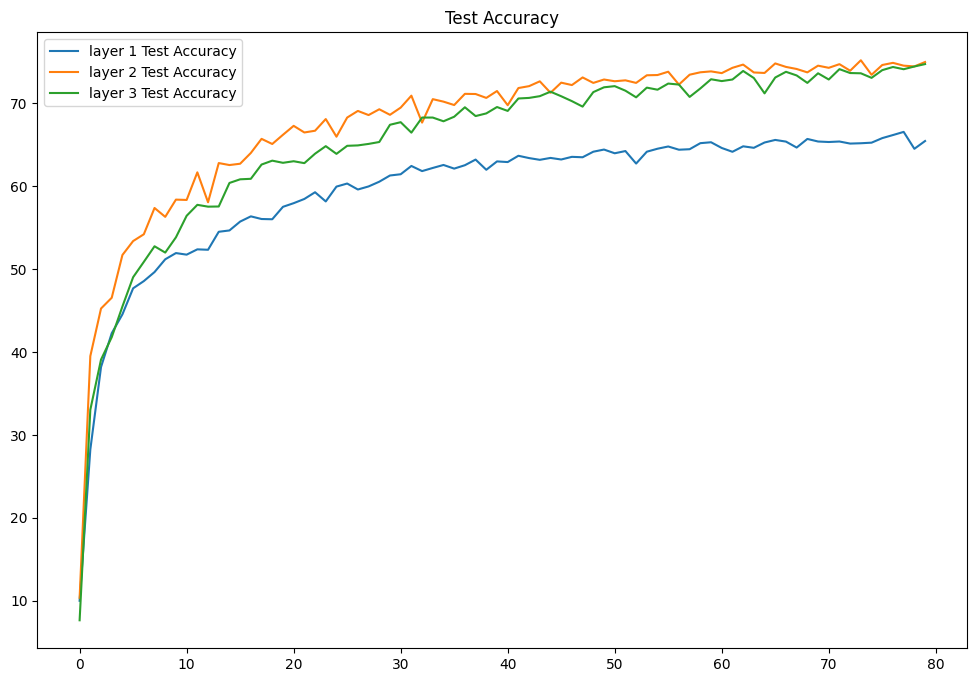

In [100]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12, 8))
plt.plot(df['卷积层1-acc'], label = 'layer 1 Test Accuracy')
plt.plot(df['卷积层2-acc'], label = 'layer 2 Test Accuracy')
plt.plot(df['卷积层3-acc'], label = 'layer 3 Test Accuracy')
plt.legend()
plt.title('Test Accuracy')

Text(0.5, 1.0, 'Train Loss')

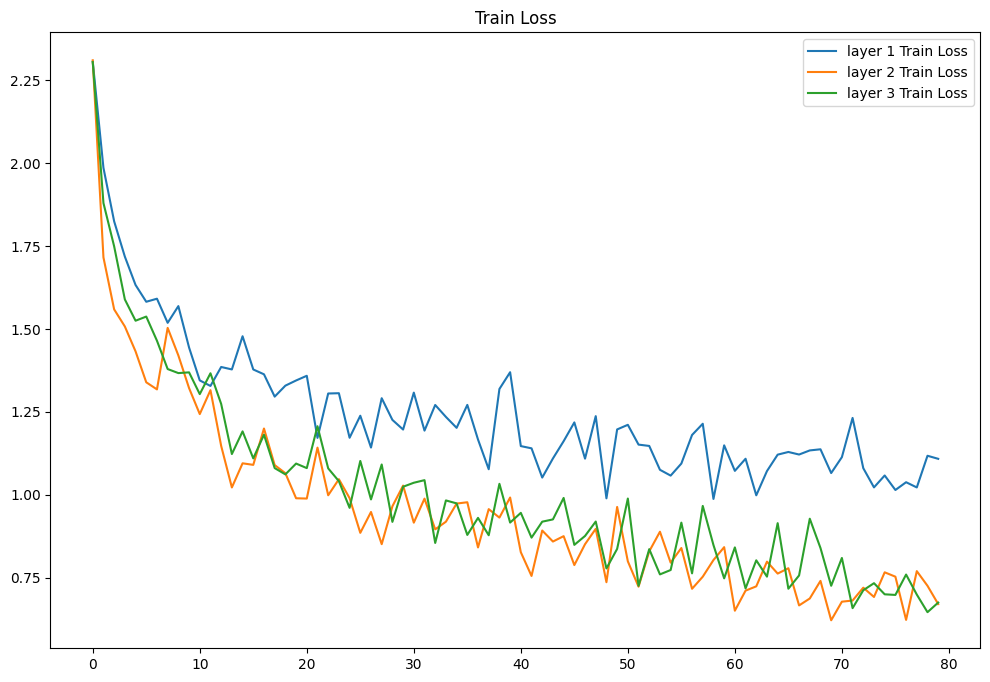

In [101]:
plt.figure(figsize = (12, 8))
plt.plot(df['卷积层1-loss'], label = 'layer 1 Train Loss')
plt.plot(df['卷积层2-loss'], label = 'layer 2 Train Loss')
plt.plot(df['卷积层3-loss'], label = 'layer 3 Train Loss')
plt.legend()
plt.title('Train Loss')

卷积核的个数

In [102]:
class Model_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=3,
                                             out_channels=64,
                                             kernel_size=3,  # 将卷积核改为 3x3
                                             stride=1,
                                             padding=1),  # 将 padding 改为 1，保持输出尺寸
                                   nn.ReLU(),
                                   nn.MaxPool2d(2),)
        self.conv2 = nn.Sequential(nn.Conv2d(64, 128, 3, 1, 1),  # 将卷积核改为 3x3
                                   nn.ReLU(),
                                   nn.MaxPool2d(2),)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sequential(nn.Flatten(),
                                 nn.Linear(128 * 8 * 8, 256),  # 将输入通道数改为 128，计算输出尺寸为 8 * 8
                                 nn.ReLU(),
                                 self.dropout,
                                 nn.Linear(256, 10),)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.dropout(x)
        output = self.out(x)
        return output


class Model_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=3,
                                             out_channels=64,
                                             kernel_size=5,  # 将卷积核改为 5x5
                                             stride=1,
                                             padding=2),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2),)
        self.conv2 = nn.Sequential(nn.Conv2d(64, 128, 5, 1, 2),  # 将卷积核改为 5x5
                                   nn.ReLU(),
                                   nn.MaxPool2d(2),)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sequential(nn.Flatten(),
                                 nn.Linear(128 * 8 * 8, 256),  # 将输入通道数改为 128，计算输出尺寸为 8 * 8
                                 nn.ReLU(),
                                 self.dropout,
                                 nn.Linear(256, 10),)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.dropout(x)
        output = self.out(x)
        return output

class Model_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=3,
                                             out_channels=64,
                                             kernel_size=7,  # 将卷积核改为 7x7
                                             stride=1,
                                             padding=3),  # 将 padding 改为 3，保持输出尺寸
                                   nn.ReLU(),
                                   nn.MaxPool2d(2),)
        self.conv2 = nn.Sequential(nn.Conv2d(64, 128, 7, 1, 3),  # 将卷积核改为 7x7
                                   nn.ReLU(),
                                   nn.MaxPool2d(2),)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sequential(nn.Flatten(),
                                 nn.Linear(128 * 8 * 8, 256),  # 将输入通道数改为 128，计算输出尺寸为 8 * 8
                                 nn.ReLU(),
                                 self.dropout,
                                 nn.Linear(256, 10),)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.dropout(x)
        output = self.out(x)
        return output

In [103]:
def train_test(a):
    #定义准确率作为评估标准
    def accuracy(predictions, labels):
        pred = torch.max(predictions.data, 1)[1]            #torch.max()[0]返回最大值 torch.max()[1]返回最大值位置，既预测值
        rights = pred.eq(labels.data.view_as(pred)).sum()
        return rights, len(labels) 
    models = [Model_1(), Model_2(), Model_3()]
    net = models[a]
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    net.cuda()
    test_right = []
    train_loss = []

    for epoch in range(num_epochs):
        train_rights = []
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.cuda(), target.cuda()
            net.train()
            output = net(data)
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            right = accuracy(output, target)
            train_rights.append(right)
            
            if batch_idx % 50 == 0:
                net.eval()
                val_rights = []
                
                for (data, target) in test_loader:
                    data, target = data.cuda(), target.cuda()
                    output = net(data)
                    right = accuracy(output, target)
                    val_rights.append(right)
                
                train_r = (sum([tup[0] for tup in train_rights]), sum([tup[1] for tup in train_rights]))
                val_r = (sum([tup[0] for tup in val_rights]), sum([tup[1] for tup in val_rights]))
                test_right.append((100*val_r[0]/val_r[1]).cpu().numpy())
                train_loss.append(loss.data.cpu().numpy())
                print(f'当前epoch:{epoch} [{batch_idx*batch_size}/{len(train_loader.dataset)}]   \
                    损失：{loss.data:.6f}  训练集准确率：{100*train_r[0]/train_r[1]:.2f}%   测试集准确率：{100*val_r[0]/val_r[1]:.2f}%')
    return test_right, train_loss

In [104]:
test_right, train_loss = train_test(0)
df['3 * 3 kenel-acc'] = test_right
df['3 * 3 kenel-loss'] = train_loss

当前epoch:0 [0/50000]                       损失：2.305616  训练集准确率：6.64%   测试集准确率：10.06%
当前epoch:0 [12800/50000]                       损失：1.688614  训练集准确率：29.66%   测试集准确率：42.43%
当前epoch:0 [25600/50000]                       损失：1.565806  训练集准确率：35.29%   测试集准确率：47.36%
当前epoch:0 [38400/50000]                       损失：1.408759  训练集准确率：38.72%   测试集准确率：50.51%
当前epoch:1 [0/50000]                       损失：1.382729  训练集准确率：49.61%   测试集准确率：52.07%
当前epoch:1 [12800/50000]                       损失：1.380636  训练集准确率：50.79%   测试集准确率：55.94%
当前epoch:1 [25600/50000]                       损失：1.345217  训练集准确率：51.93%   测试集准确率：56.41%
当前epoch:1 [38400/50000]                       损失：1.196215  训练集准确率：52.65%   测试集准确率：58.04%
当前epoch:2 [0/50000]                       损失：1.227659  训练集准确率：54.69%   测试集准确率：59.58%
当前epoch:2 [12800/50000]                       损失：1.318724  训练集准确率：56.72%   测试集准确率：61.38%
当前epoch:2 [25600/50000]                       损失：1.215227  训练集准确率：57.30%   测试集准确率：61.12%
当前epoch:2 [38400/50000]           

In [105]:
test_right, train_loss = train_test(1)
df['5 * 5 kenel-acc'] = test_right
df['5 * 5 kenel-loss'] = train_loss

当前epoch:0 [0/50000]                       损失：2.305068  训练集准确率：9.77%   测试集准确率：10.20%
当前epoch:0 [12800/50000]                       损失：1.772963  训练集准确率：22.99%   测试集准确率：33.53%
当前epoch:0 [25600/50000]                       损失：1.558372  训练集准确率：30.30%   测试集准确率：44.71%
当前epoch:0 [38400/50000]                       损失：1.596075  训练集准确率：34.77%   测试集准确率：48.01%
当前epoch:1 [0/50000]                       损失：1.412600  训练集准确率：50.78%   测试集准确率：51.23%
当前epoch:1 [12800/50000]                       损失：1.346442  训练集准确率：49.10%   测试集准确率：53.42%
当前epoch:1 [25600/50000]                       损失：1.254571  训练集准确率：49.97%   测试集准确率：53.58%
当前epoch:1 [38400/50000]                       损失：1.399194  训练集准确率：50.36%   测试集准确率：55.93%
当前epoch:2 [0/50000]                       损失：1.418045  训练集准确率：50.00%   测试集准确率：56.18%
当前epoch:2 [12800/50000]                       损失：1.248996  训练集准确率：54.31%   测试集准确率：59.45%
当前epoch:2 [25600/50000]                       损失：1.308068  训练集准确率：54.68%   测试集准确率：58.81%
当前epoch:2 [38400/50000]           

In [106]:
test_right, train_loss = train_test(2)
df['7 * 7 kenel-acc'] = test_right
df['7 * 7 kenel-loss'] = train_loss

当前epoch:0 [0/50000]                       损失：2.306116  训练集准确率：10.16%   测试集准确率：10.00%
当前epoch:0 [12800/50000]                       损失：1.884121  训练集准确率：19.77%   测试集准确率：32.41%
当前epoch:0 [25600/50000]                       损失：1.722085  训练集准确率：25.83%   测试集准确率：37.41%
当前epoch:0 [38400/50000]                       损失：1.671928  训练集准确率：29.29%   测试集准确率：41.35%
当前epoch:1 [0/50000]                       损失：1.519338  训练集准确率：46.48%   测试集准确率：44.60%
当前epoch:1 [12800/50000]                       损失：1.482051  训练集准确率：43.41%   测试集准确率：47.14%
当前epoch:1 [25600/50000]                       损失：1.499431  训练集准确率：44.33%   测试集准确率：50.09%
当前epoch:1 [38400/50000]                       损失：1.436579  训练集准确率：45.08%   测试集准确率：48.98%
当前epoch:2 [0/50000]                       损失：1.456091  训练集准确率：47.66%   测试集准确率：51.70%
当前epoch:2 [12800/50000]                       损失：1.397289  训练集准确率：49.49%   测试集准确率：53.55%
当前epoch:2 [25600/50000]                       损失：1.297172  训练集准确率：49.94%   测试集准确率：55.27%
当前epoch:2 [38400/50000]          

In [107]:
df

,base-loss,base-acc,ReLu-acc,ReLu-loss,Sigmoid-acc,Sigmoid-loss,Tanh-acc,Tanh-loss,LeakyReLu-acc,LeakyReLu-loss,...,卷积层2-acc,卷积层2-loss,卷积层3-acc,卷积层3-loss,3 * 3 kenel-acc,3 * 3 kenel-loss,5 * 5 kenel-acc,5 * 5 kenel-loss,7 * 7 kenel-acc,7 * 7 kenel-loss
0,2.3050797,15.679999,12.099999,2.3035283,10.0,2.3348436,11.969999,2.3078287,10.0,2.3160293,...,10.36,2.3099813,7.6499996,2.3044503,10.059999,2.3056161,10.2,2.305068,10.0,2.3061159
1,1.6723946,38.829998,36.7,1.8042097,10.009999,2.319303,42.25,1.7017035,38.53,1.7316606,...,39.52,1.7157662,33.05,1.8796414,42.43,1.6886144,33.53,1.772963,32.41,1.884121
2,1.6251671,42.8,43.73,1.7657076,22.769999,2.2779984,48.78,1.5738242,42.35,1.7341067,...,45.26,1.5591398,39.1,1.7491406,47.36,1.5658062,44.71,1.5583717,37.41,1.7220848
3,1.4236944,47.649998,47.62,1.5684221,24.88,2.0952673,50.6,1.5182312,45.87,1.5359819,...,46.559998,1.5075716,41.8,1.5891492,50.51,1.4087585,48.01,1.5960753,41.35,1.6719279
4,1.5529698,50.26,47.37,1.5623573,26.949999,1.9834163,53.05,1.4236951,48.649998,1.6255507,...,51.719997,1.4325575,45.51,1.5249639,52.07,1.3827294,51.23,1.4125996,44.6,1.5193385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.6842479,73.82,74.36,0.73001474,57.02,1.2048417,68.689995,0.8536566,75.08,0.6168025,...,74.64,0.7533738,74.02,0.6983695,75.229996,0.6051125,73.439995,0.71183926,71.63,0.78095746
76,0.72153044,74.71,73.479996,0.70796096,56.969997,1.3185892,70.869995,0.8066182,73.34,0.6673581,...,74.9,0.62312764,74.4,0.7598011,74.02,0.63336444,73.78,0.63723564,73.21,0.87042123
77,0.6947372,74.509995,73.4,0.66758436,57.309998,1.2566977,71.17,0.8207205,75.15,0.6528687,...,74.56,0.770116,74.13,0.6994574,75.479996,0.65365785,72.509995,0.7260463,73.67,0.85573894
78,0.6812734,74.369995,74.45,0.6424976,57.649998,1.1645101,70.63,0.80494565,73.89,0.6270602,...,74.47,0.7259061,74.46,0.646381,75.24,0.76066726,73.25,0.6459609,73.46,0.745682


Text(0.5, 1.0, 'Test Accuracy')

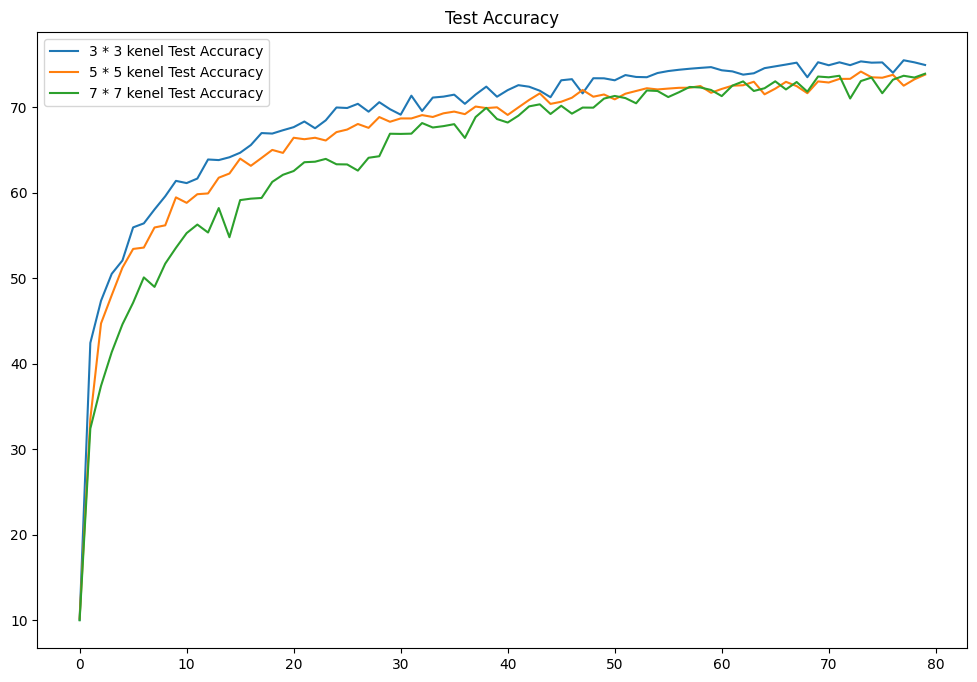

In [108]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12, 8))
plt.plot(df['3 * 3 kenel-acc'], label = '3 * 3 kenel Test Accuracy')
plt.plot(df['5 * 5 kenel-acc'], label = '5 * 5 kenel Test Accuracy')
plt.plot(df['7 * 7 kenel-acc'], label = '7 * 7 kenel Test Accuracy')
plt.legend()
plt.title('Test Accuracy')

Text(0.5, 1.0, 'Train Loss')

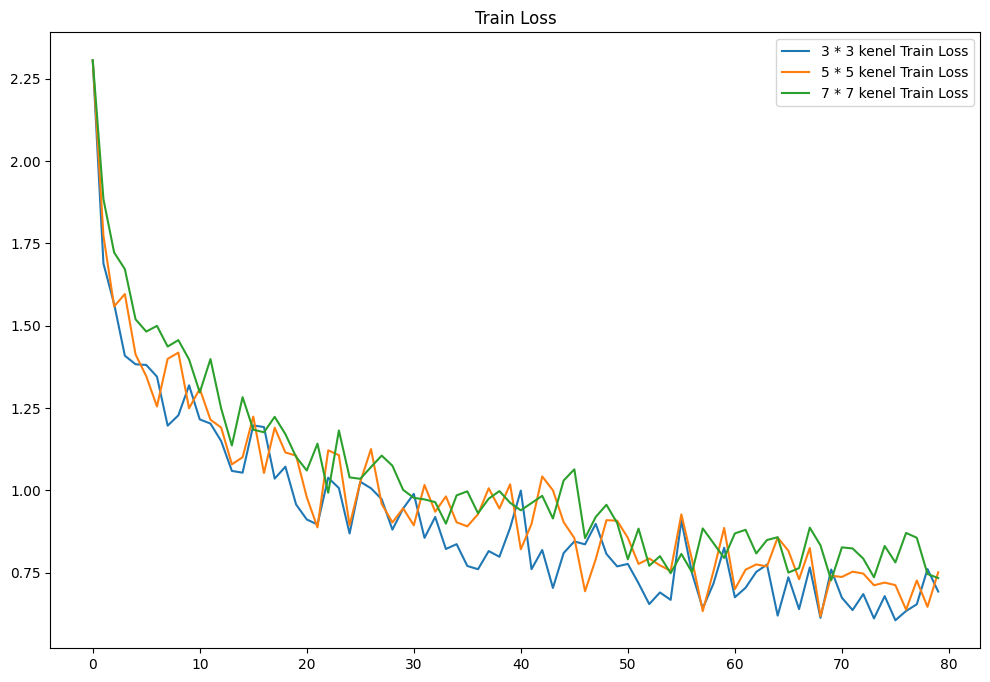

In [109]:
plt.figure(figsize = (12, 8))
plt.plot(df['3 * 3 kenel-loss'], label = '3 * 3 kenel Train Loss')
plt.plot(df['5 * 5 kenel-loss'], label = '5 * 5 kenel Train Loss')
plt.plot(df['7 * 7 kenel-loss'], label = '7 * 7 kenel Train Loss')
plt.legend()
plt.title('Train Loss')

输出通道

In [111]:
class Model_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=3,
                                             out_channels=64,
                                             kernel_size=3,  # 将卷积核改为 3x3
                                             stride=1,
                                             padding=1),  # 将 padding 改为 1，保持输出尺寸
                                   nn.ReLU(),
                                   nn.MaxPool2d(2),)
        self.conv2 = nn.Sequential(nn.Conv2d(64, 128, 3, 1, 1),  # 将卷积核改为 3x3
                                   nn.ReLU(),
                                   nn.MaxPool2d(2),)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sequential(nn.Flatten(),
                                 nn.Linear(128 * 8 * 8, 256),  # 将输入通道数改为 128，计算输出尺寸为 8 * 8
                                 nn.ReLU(),
                                 self.dropout,
                                 nn.Linear(256, 10),)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.dropout(x)
        output = self.out(x)
        return output
    

# 定义准确率作为评估标准
def accuracy(predictions, labels):
    pred = torch.max(predictions.data, 1)[1]            # torch.max()[0]返回最大值 torch.max()[1]返回最大值位置，既预测值
    rights = pred.eq(labels.data.view_as(pred)).sum()
    return rights, len(labels) 
net = Model_1()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
net.cuda()
test_right = []
train_loss = []

for epoch in range(num_epochs):
    train_rights = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        net.train()
        output = net(data)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        right = accuracy(output, target)
        train_rights.append(right)
        
        if batch_idx % 50 == 0:
            net.eval()
            val_rights = []
            
            for (data, target) in test_loader:
                data, target = data.cuda(), target.cuda()
                output = net(data)
                right = accuracy(output, target)
                val_rights.append(right)
            
            train_r = (sum([tup[0] for tup in train_rights]), sum([tup[1] for tup in train_rights]))
            val_r = (sum([tup[0] for tup in val_rights]), sum([tup[1] for tup in val_rights]))
            test_right.append((100*val_r[0]/val_r[1]).cpu().numpy())
            train_loss.append(loss.data.cpu().numpy())
            print(f'当前epoch:{epoch} [{batch_idx*batch_size}/{len(train_loader.dataset)}]   \
                损失：{loss.data:.6f}  训练集准确率：{100*train_r[0]/train_r[1]:.2f}%   测试集准确率：{100*val_r[0]/val_r[1]:.2f}%')

当前epoch:0 [0/50000]                   损失：2.302690  训练集准确率：10.55%   测试集准确率：10.00%
当前epoch:0 [12800/50000]                   损失：1.735323  训练集准确率：27.01%   测试集准确率：39.80%
当前epoch:0 [25600/50000]                   损失：1.470340  训练集准确率：33.19%   测试集准确率：46.48%
当前epoch:0 [38400/50000]                   损失：1.653634  训练集准确率：36.82%   测试集准确率：49.29%
当前epoch:1 [0/50000]                   损失：1.319025  训练集准确率：51.56%   测试集准确率：51.45%
当前epoch:1 [12800/50000]                   损失：1.428784  训练集准确率：49.58%   测试集准确率：52.79%
当前epoch:1 [25600/50000]                   损失：1.371654  训练集准确率：50.50%   测试集准确率：55.96%
当前epoch:1 [38400/50000]                   损失：1.374354  训练集准确率：51.09%   测试集准确率：57.64%
当前epoch:2 [0/50000]                   损失：1.382156  训练集准确率：51.17%   测试集准确率：58.41%
当前epoch:2 [12800/50000]                   损失：1.341835  训练集准确率：54.96%   测试集准确率：59.49%
当前epoch:2 [25600/50000]                   损失：1.206322  训练集准确率：54.76%   测试集准确率：60.15%
当前epoch:2 [38400/50000]                   损失：1.300626  训练集准确率：55.52%   测试集准确率

In [112]:
df['fc256-acc'] = test_right
df['fc256-loss'] = train_loss

In [113]:
class Model_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=3,
                                             out_channels=64,
                                             kernel_size=3,
                                             stride=1,
                                             padding=1),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2),)
        self.conv2 = nn.Sequential(nn.Conv2d(64, 128, 3, 1, 1),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2),)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sequential(nn.Flatten(),
                                 nn.Linear(128 * 8 * 8, 512),  # 将第一个全连接层输出通道数改为 512
                                 nn.ReLU(),
                                 self.dropout,
                                 nn.Linear(512, 10),)  # 将第二个全连接层输出通道数改为 512

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.dropout(x)
        output = self.out(x)
        return output

    
#定义准确率作为评估标准
def accuracy(predictions, labels):
    pred = torch.max(predictions.data, 1)[1]            #torch.max()[0]返回最大值 torch.max()[1]返回最大值位置，既预测值
    rights = pred.eq(labels.data.view_as(pred)).sum()
    return rights, len(labels) 
net = Model_2()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
net.cuda()
test_right = []
train_loss = []

for epoch in range(num_epochs):
    train_rights = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        net.train()
        output = net(data)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        right = accuracy(output, target)
        train_rights.append(right)
        
        if batch_idx % 50 == 0:
            net.eval()
            val_rights = []
            
            for (data, target) in test_loader:
                data, target = data.cuda(), target.cuda()
                output = net(data)
                right = accuracy(output, target)
                val_rights.append(right)
            
            train_r = (sum([tup[0] for tup in train_rights]), sum([tup[1] for tup in train_rights]))
            val_r = (sum([tup[0] for tup in val_rights]), sum([tup[1] for tup in val_rights]))
            test_right.append((100*val_r[0]/val_r[1]).cpu().numpy())
            train_loss.append(loss.data.cpu().numpy())
            print(f'当前epoch:{epoch + 1} [{batch_idx*batch_size}/{len(train_loader.dataset)}]   \
                损失：{loss.data:.6f}  训练集准确率：{100*train_r[0]/train_r[1]:.2f}%   测试集准确率：{100*val_r[0]/val_r[1]:.2f}%')

当前epoch:1 [0/50000]                   损失：2.302298  训练集准确率：14.45%   测试集准确率：10.00%
当前epoch:1 [12800/50000]                   损失：1.714867  训练集准确率：29.42%   测试集准确率：41.42%
当前epoch:1 [25600/50000]                   损失：1.500658  训练集准确率：35.93%   测试集准确率：48.75%
当前epoch:1 [38400/50000]                   损失：1.432301  训练集准确率：39.55%   测试集准确率：51.30%
当前epoch:2 [0/50000]                   损失：1.248969  训练集准确率：57.03%   测试集准确率：54.00%
当前epoch:2 [12800/50000]                   损失：1.339720  训练集准确率：52.39%   测试集准确率：55.66%
当前epoch:2 [25600/50000]                   损失：1.282519  训练集准确率：53.08%   测试集准确率：56.50%
当前epoch:2 [38400/50000]                   损失：1.272312  训练集准确率：53.68%   测试集准确率：58.48%
当前epoch:3 [0/50000]                   损失：1.140574  训练集准确率：62.89%   测试集准确率：58.80%
当前epoch:3 [12800/50000]                   损失：1.283306  训练集准确率：58.53%   测试集准确率：61.88%
当前epoch:3 [25600/50000]                   损失：1.100403  训练集准确率：58.42%   测试集准确率：61.59%
当前epoch:3 [38400/50000]                   损失：1.038360  训练集准确率：58.93%   测试集准确率

In [114]:
df['fc512-acc'] = test_right
df['fc512-loss'] = train_loss

In [115]:
class Model_3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=3,
                                             out_channels=64,
                                             kernel_size=3,
                                             stride=1,
                                             padding=1),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2),)
        self.conv2 = nn.Sequential(nn.Conv2d(64, 128, 3, 1, 1),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2),)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sequential(nn.Flatten(),
                                 nn.Linear(128 * 8 * 8, 1024),  # 将第一个全连接层输出通道数改为 1024
                                 nn.ReLU(),
                                 self.dropout,
                                 nn.Linear(1024, 10),)  # 将第二个全连接层输出通道数改为 1024

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.dropout(x)
        output = self.out(x)
        return output

#定义准确率作为评估标准
def accuracy(predictions, labels):
    pred = torch.max(predictions.data, 1)[1]            #torch.max()[0]返回最大值 torch.max()[1]返回最大值位置，既预测值
    rights = pred.eq(labels.data.view_as(pred)).sum()
    return rights, len(labels) 
net = Model_3()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
net.cuda()
test_right = []
train_loss = []

for epoch in range(num_epochs):
    train_rights = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        net.train()
        output = net(data)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        right = accuracy(output, target)
        train_rights.append(right)
        
        if batch_idx % 50 == 0:
            net.eval()
            val_rights = []
            
            for (data, target) in test_loader:
                data, target = data.cuda(), target.cuda()
                output = net(data)
                right = accuracy(output, target)
                val_rights.append(right)
            
            train_r = (sum([tup[0] for tup in train_rights]), sum([tup[1] for tup in train_rights]))
            val_r = (sum([tup[0] for tup in val_rights]), sum([tup[1] for tup in val_rights]))
            test_right.append((100*val_r[0]/val_r[1]).cpu().numpy())
            train_loss.append(loss.data.cpu().numpy())
            print(f'当前epoch:{epoch + 1} [{batch_idx*batch_size}/{len(train_loader.dataset)}]   \
                损失：{loss.data:.6f}  训练集准确率：{100*train_r[0]/train_r[1]:.2f}%   测试集准确率：{100*val_r[0]/val_r[1]:.2f}%')

当前epoch:1 [0/50000]                   损失：2.298735  训练集准确率：12.50%   测试集准确率：10.00%
当前epoch:1 [12800/50000]                   损失：1.730333  训练集准确率：27.28%   测试集准确率：42.20%
当前epoch:1 [25600/50000]                   损失：1.461151  训练集准确率：34.75%   测试集准确率：47.95%
当前epoch:1 [38400/50000]                   损失：1.456652  训练集准确率：38.29%   测试集准确率：51.31%
当前epoch:2 [0/50000]                   损失：1.401887  训练集准确率：50.00%   测试集准确率：51.34%
当前epoch:2 [12800/50000]                   损失：1.359316  训练集准确率：52.19%   测试集准确率：55.75%
当前epoch:2 [25600/50000]                   损失：1.163539  训练集准确率：52.95%   测试集准确率：57.49%
当前epoch:2 [38400/50000]                   损失：1.364372  训练集准确率：53.58%   测试集准确率：58.99%
当前epoch:3 [0/50000]                   损失：1.030498  训练集准确率：60.55%   测试集准确率：59.69%
当前epoch:3 [12800/50000]                   损失：1.206494  训练集准确率：58.85%   测试集准确率：60.48%
当前epoch:3 [25600/50000]                   损失：1.149234  训练集准确率：59.07%   测试集准确率：62.05%
当前epoch:3 [38400/50000]                   损失：1.077143  训练集准确率：59.21%   测试集准确率

In [116]:
df['fc1024-acc'] = test_right
df['fc1024-loss'] = train_loss

In [117]:
df

,base-loss,base-acc,ReLu-acc,ReLu-loss,Sigmoid-acc,Sigmoid-loss,Tanh-acc,Tanh-loss,LeakyReLu-acc,LeakyReLu-loss,...,5 * 5 kenel-acc,5 * 5 kenel-loss,7 * 7 kenel-acc,7 * 7 kenel-loss,fc256-acc,fc256-loss,fc512-acc,fc512-loss,fc1024-acc,fc1024-loss
0,2.3050797,15.679999,12.099999,2.3035283,10.0,2.3348436,11.969999,2.3078287,10.0,2.3160293,...,10.2,2.305068,10.0,2.3061159,10.0,2.3026896,10.0,2.3022976,10.0,2.2987347
1,1.6723946,38.829998,36.7,1.8042097,10.009999,2.319303,42.25,1.7017035,38.53,1.7316606,...,33.53,1.772963,32.41,1.884121,39.8,1.735323,41.42,1.7148665,42.2,1.7303327
2,1.6251671,42.8,43.73,1.7657076,22.769999,2.2779984,48.78,1.5738242,42.35,1.7341067,...,44.71,1.5583717,37.41,1.7220848,46.48,1.4703399,48.75,1.5006577,47.949997,1.4611512
3,1.4236944,47.649998,47.62,1.5684221,24.88,2.0952673,50.6,1.5182312,45.87,1.5359819,...,48.01,1.5960753,41.35,1.6719279,49.289997,1.6536338,51.3,1.4323008,51.309998,1.4566523
4,1.5529698,50.26,47.37,1.5623573,26.949999,1.9834163,53.05,1.4236951,48.649998,1.6255507,...,51.23,1.4125996,44.6,1.5193385,51.449997,1.3190252,54.0,1.2489688,51.34,1.4018872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.6842479,73.82,74.36,0.73001474,57.02,1.2048417,68.689995,0.8536566,75.08,0.6168025,...,73.439995,0.71183926,71.63,0.78095746,74.67,0.6611516,76.36,0.48690814,76.4,0.4845152
76,0.72153044,74.71,73.479996,0.70796096,56.969997,1.3185892,70.869995,0.8066182,73.34,0.6673581,...,73.78,0.63723564,73.21,0.87042123,74.72,0.7504811,75.689995,0.5449236,77.42,0.5038399
77,0.6947372,74.509995,73.4,0.66758436,57.309998,1.2566977,71.17,0.8207205,75.15,0.6528687,...,72.509995,0.7260463,73.67,0.85573894,74.57,0.7325109,76.1,0.5219386,76.939995,0.48512068
78,0.6812734,74.369995,74.45,0.6424976,57.649998,1.1645101,70.63,0.80494565,73.89,0.6270602,...,73.25,0.6459609,73.46,0.745682,74.88,0.69797844,76.439995,0.5420342,76.38,0.5284087


Text(0.5, 1.0, 'Test Accuracy')

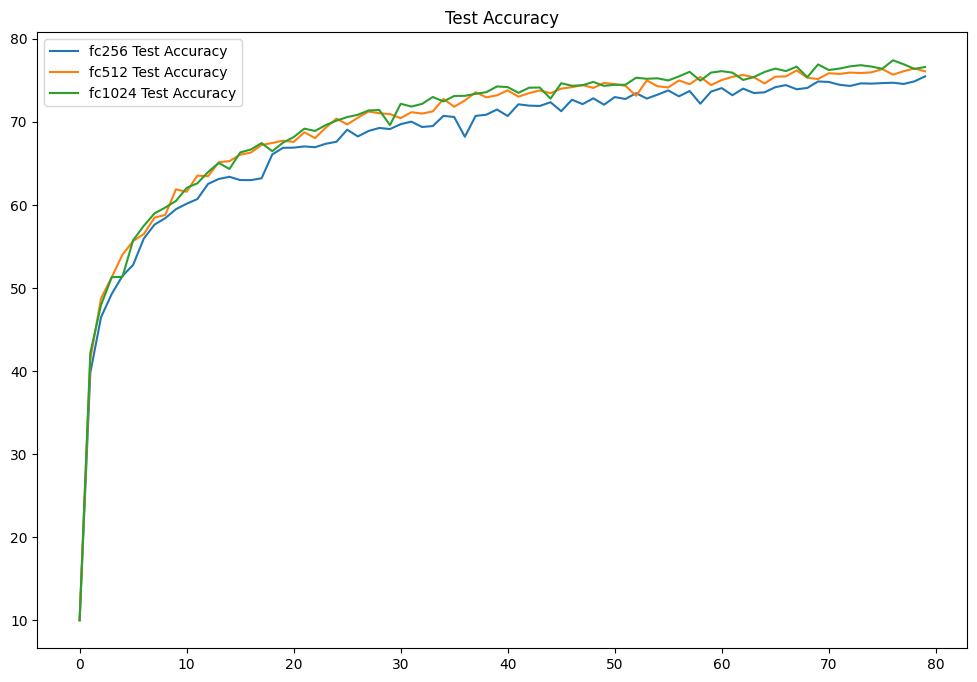

In [118]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12, 8))
plt.plot(df['fc256-acc'], label = 'fc256 Test Accuracy')
plt.plot(df['fc512-acc'], label = 'fc512 Test Accuracy')
plt.plot(df['fc1024-acc'], label = 'fc1024 Test Accuracy')
plt.legend()
plt.title('Test Accuracy')

Text(0.5, 1.0, 'Train Loss')

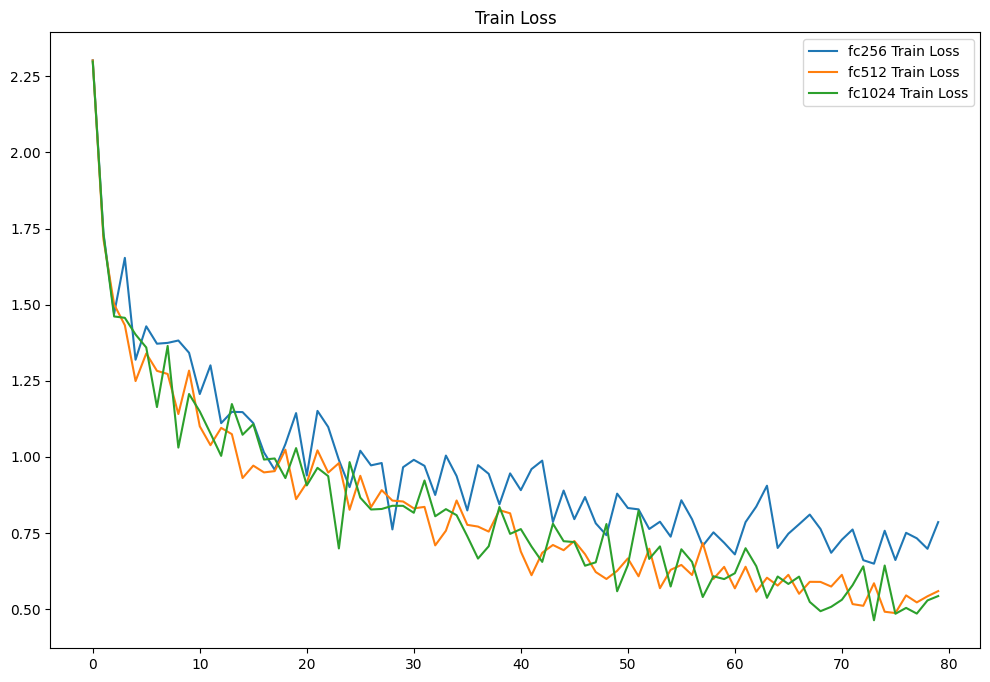

In [119]:
plt.figure(figsize = (12, 8))
plt.plot(df['fc256-loss'], label = 'fc256 Train Loss')
plt.plot(df['fc512-loss'], label = 'fc512 Train Loss')
plt.plot(df['fc1024-loss'], label = 'fc1024 Train Loss')
plt.legend()
plt.title('Train Loss')

In [120]:
class Model_3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=3,
                                             out_channels=64,
                                             kernel_size=3,
                                             stride=1,
                                             padding=1),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2),)
        self.conv2 = nn.Sequential(nn.Conv2d(64, 128, 3, 1, 1),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2),)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Sequential(nn.Flatten(),
                                 nn.Linear(128 * 8 * 8, 1024),  # 将第一个全连接层输出通道数改为 1024
                                 nn.ReLU(),
                                 self.dropout,
                                 nn.Linear(1024, 10),)  # 将第二个全连接层输出通道数改为 1024

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.dropout(x)
        output = self.out(x)
        return output

#定义准确率作为评估标准
def accuracy(predictions, labels):
    pred = torch.max(predictions.data, 1)[1]            #torch.max()[0]返回最大值 torch.max()[1]返回最大值位置，既预测值
    rights = pred.eq(labels.data.view_as(pred)).sum()
    return rights, len(labels) 
net = Model_3()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
net.cuda()
test_right = []
train_loss = []

for epoch in range(num_epochs):
    train_rights = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        net.train()
        output = net(data)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        right = accuracy(output, target)
        train_rights.append(right)
        
        if batch_idx % 50 == 0:
            net.eval()
            val_rights = []
            
            for (data, target) in test_loader:
                data, target = data.cuda(), target.cuda()
                output = net(data)
                right = accuracy(output, target)
                val_rights.append(right)
            
            train_r = (sum([tup[0] for tup in train_rights]), sum([tup[1] for tup in train_rights]))
            val_r = (sum([tup[0] for tup in val_rights]), sum([tup[1] for tup in val_rights]))
            test_right.append((100*val_r[0]/val_r[1]).cpu().numpy())
            train_loss.append(loss.data.cpu().numpy())
            print(f'当前epoch:{epoch + 1} [{batch_idx*batch_size}/{len(train_loader.dataset)}]   \
                损失：{loss.data:.6f}  训练集准确率：{100*train_r[0]/train_r[1]:.2f}%   测试集准确率：{100*val_r[0]/val_r[1]:.2f}%')

当前epoch:1 [0/50000]                   损失：2.299250  训练集准确率：10.94%   测试集准确率：10.00%
当前epoch:1 [12800/50000]                   损失：1.585709  训练集准确率：28.46%   测试集准确率：40.38%
当前epoch:1 [25600/50000]                   损失：1.492168  训练集准确率：35.81%   测试集准确率：49.54%
当前epoch:1 [38400/50000]                   损失：1.303640  训练集准确率：39.69%   测试集准确率：51.87%
当前epoch:2 [0/50000]                   损失：1.262451  训练集准确率：56.64%   测试集准确率：54.75%
当前epoch:2 [12800/50000]                   损失：1.366400  训练集准确率：53.62%   测试集准确率：56.76%
当前epoch:2 [25600/50000]                   损失：1.306897  训练集准确率：53.85%   测试集准确率：58.17%
当前epoch:2 [38400/50000]                   损失：1.239472  训练集准确率：54.92%   测试集准确率：60.09%
当前epoch:3 [0/50000]                   损失：1.129262  训练集准确率：57.42%   测试集准确率：60.09%
当前epoch:3 [12800/50000]                   损失：1.105036  训练集准确率：59.97%   测试集准确率：62.34%
当前epoch:3 [25600/50000]                   损失：1.068413  训练集准确率：60.30%   测试集准确率：63.09%
当前epoch:3 [38400/50000]                   损失：1.086128  训练集准确率：60.88%   测试集准确率

Text(0.5, 1.0, 'Final Test Accuracy')

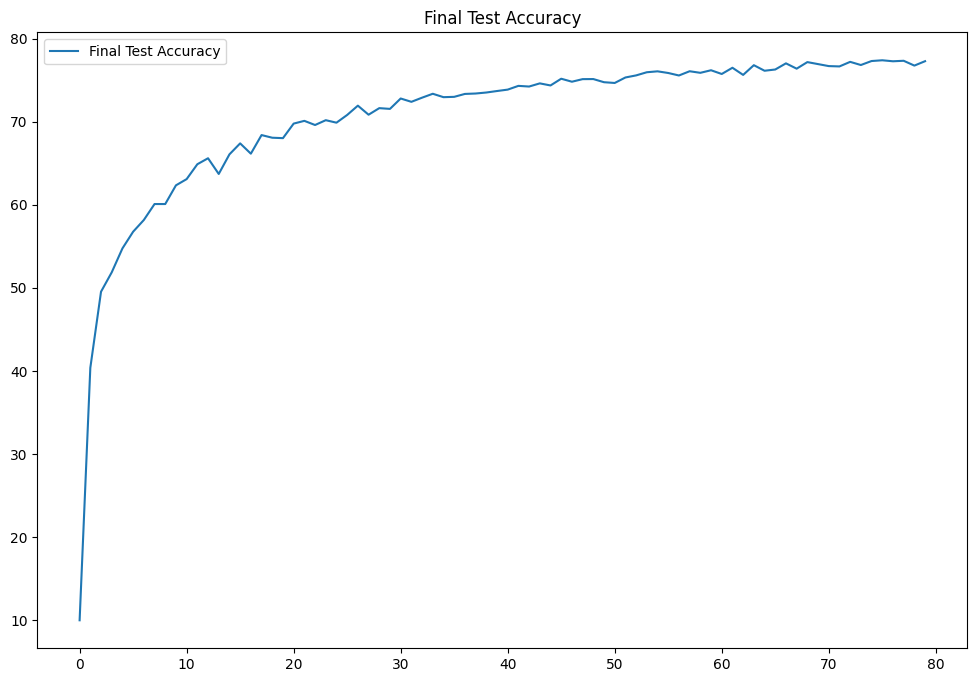

In [121]:
df1 = pd.DataFrame()
df1['loss'] = train_loss
df1['acc'] = test_right
plt.figure(figsize = (12, 8))
plt.plot(df1['acc'], label = 'Final Test Accuracy')
plt.legend()
plt.title('Final Test Accuracy')

Text(0.5, 1.0, 'Final Train Loss')

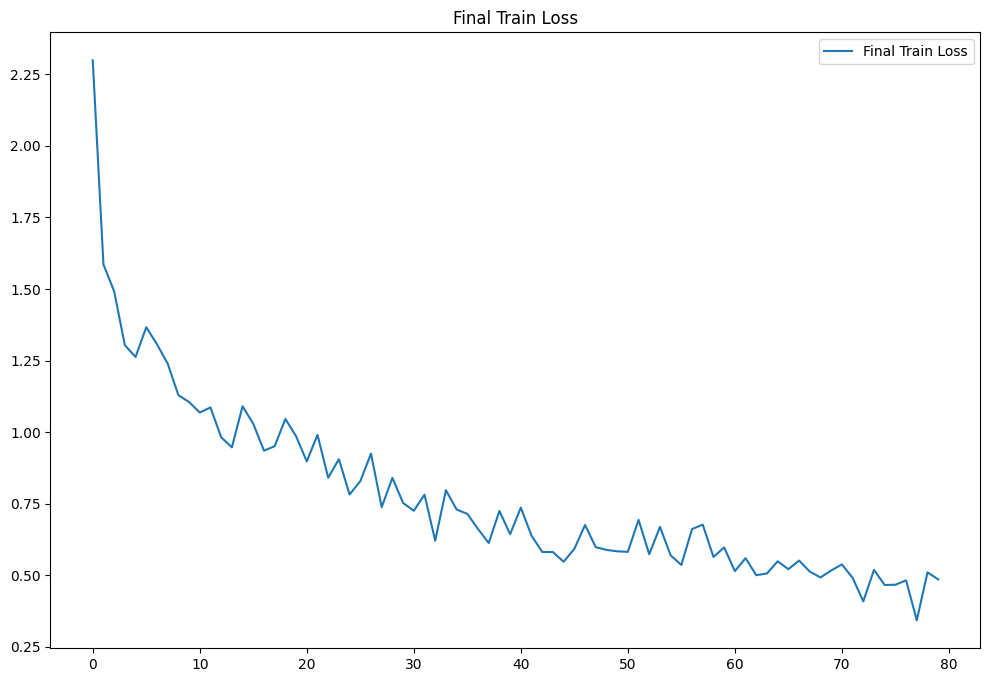

In [122]:
plt.figure(figsize = (12, 8))
plt.plot(df1['loss'], label = 'Final Train Loss')
plt.legend()
plt.title('Final Train Loss')